In [2]:
##importing required libraries
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random 
import kaggle
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

In [3]:
#Downloading Data
# Set the Kaggle dataset and file details
kaggle_dataset = 'deadskull7/fer2013'  # Example: 'zillow/zecon'
file_name = 'fer2013.csv'  # Name of the file you want to download
data_folder = '../data'

# Create data directory if it does not exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

try:
    # Download the dataset file from Kaggle
    kaggle.api.dataset_download_file(dataset=kaggle_dataset, file_name=file_name, path=data_folder)
    # Define the path to the downloaded zip file
    zip_file_path = os.path.join(data_folder, file_name+'.zip')
    
    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(data_folder)

    # Remove the zip file after extraction
    os.remove(zip_file_path)
    print('Data downloaded and extracted.')

except Exception as e:
    print(f"An error occurred: {e}")

Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013
Data downloaded and extracted.


In [4]:
##import the dataset
faces = pd.read_csv('../data/fer2013.csv')
faces.head()


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
faces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
faces.nunique()

emotion        7
pixels     34034
Usage          3
dtype: int64

In [7]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = faces['emotion'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Digust,547


In [8]:
faces['Usage'].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [9]:
faces = faces.drop(columns = ['Usage'])


In [10]:
##Lets check some of the faces
faces.sample(n=10)

,emotion,pixels
19777,5,52 45 40 30 22 23 21 28 34 33 41 39 35 41 50 5...
28939,1,7 21 20 23 63 75 69 65 66 68 78 89 104 122 132...
8156,3,127 21 28 40 42 48 63 86 107 130 139 148 155 1...
10233,6,16 14 14 14 19 36 37 44 31 19 21 24 19 25 25 2...
15442,3,167 45 19 19 36 29 7 4 5 6 7 10 20 45 63 82 95...
26531,5,255 255 255 253 255 222 99 75 88 98 108 110 12...
22331,0,119 33 39 37 37 33 30 28 30 30 39 65 94 112 12...
8486,5,255 255 255 254 255 251 162 165 215 220 216 21...
6377,3,186 198 164 138 171 163 143 143 134 164 203 19...
13402,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [11]:
#Lets create a funtion to convert the pixel values to array so that we can plot it
type(faces['pixels'][0])

str

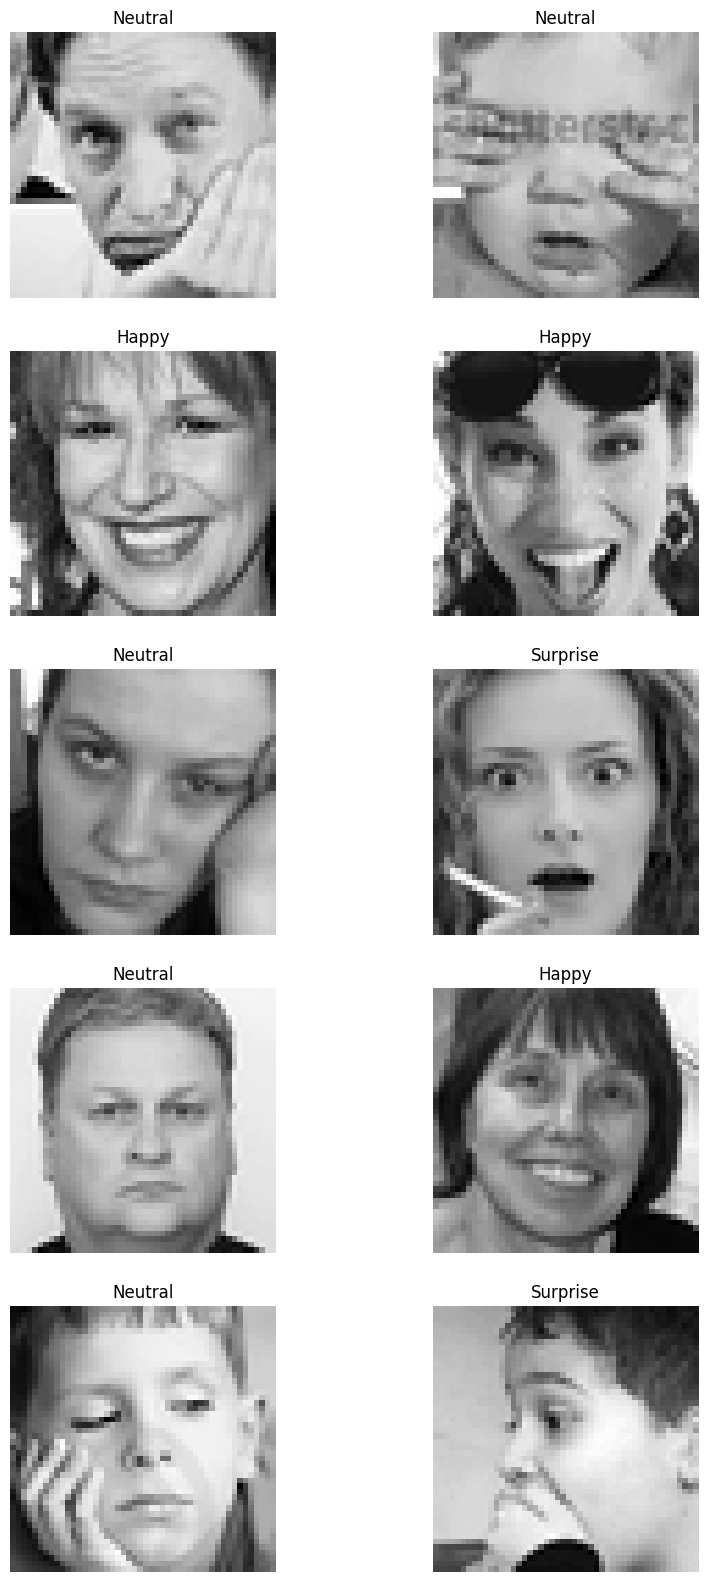

In [12]:
def get_image(row):
    pixels = row['pixels']
    emotion = emotion_map[row['emotion']]
    img = np.array(pixels.split(),dtype =float) 
    #this will give a list from the string for instance [233,181,135]. 
    #pixels.split gives a list and np.array converts the list to array
    img = img.reshape(48,48) # reshape the 1d array to 2d array of dimensions 48x48
    return (img.astype(np.uint8), emotion) #return tuple of img with required datatype and emotion label

samples = faces.sample(n = 10).reset_index() #getting 8 random
plt.figure(0, figsize=(10,20))
for index, row in samples.iterrows():
    img = get_image(row)
    plt.subplot(5,2,index+1)
    plt.imshow(img[0],cmap='gray')
    plt.title(img[1])
    plt.axis('off')
    
plt.show()  

In [13]:
classes, class_counts = np.unique(faces['emotion'], return_counts=True)
mid_count = np.median(class_counts)  #this returns the max number of samples in the classes that is happy
print(f'The median number of samples in a class is',mid_count)

The median number of samples in a class is 5121.0


In [14]:
print(classes, class_counts) #just for visualization

[0 1 2 3 4 5 6] [4953  547 5121 8989 6077 4002 6198]


In [15]:
#Use tensorflow's Data augmentation tool to augment the images
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
) #apply transformations to images so new images can be generated from the  images

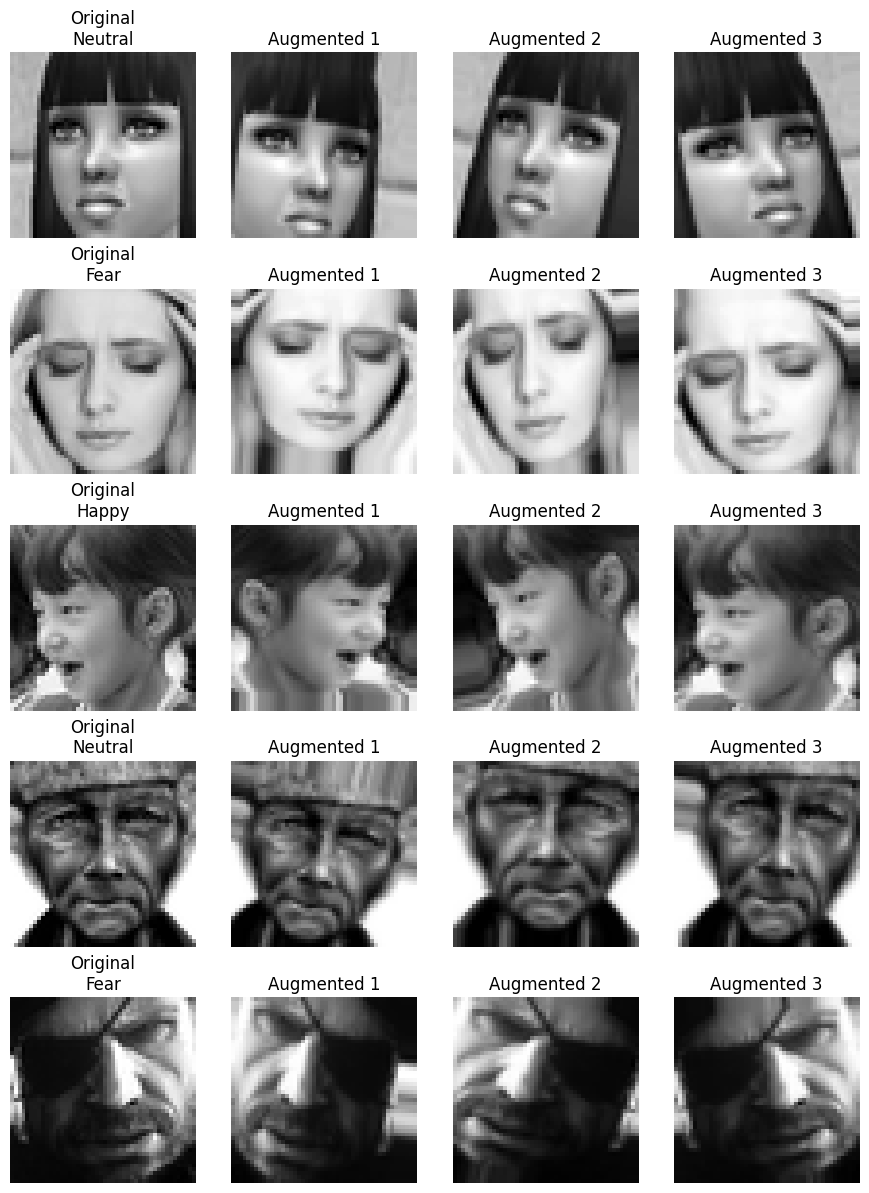

In [17]:
#Before applying in the dataset, lets show what type of augmentation does the datagen do
samples = faces.sample(n=5).reset_index(drop=True)
# Create a figure with a grid of 5 rows and 4 columns (1 for original, 3 for augmented)
plt.figure(figsize=(9,12 ))

# Loop through the sampled images and plot each one
for index, row in samples.iterrows():
    img, emotion_label = get_image(row)  # Get image and emotion label
    
    # Display original image
    plt.subplot(5, 4, index*4+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{emotion_label}")
    plt.axis('off')
    # For augmentation, tensorflow expects a 4d array in the format (batch_size, height, width, channels) 
    # Add channel dimension for grayscale images
    img = img[:, :, np.newaxis]  # Shape becomes (48, 48, 1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension for augmentation
    augmented_images = datagen.flow(img, batch_size=1) 
    
    for i in range(3):  # Show 3 augmented versions
        augmented_image = next(augmented_images)[0].astype(np.uint8)
        plt.subplot(5, 4, index*4 + 2 + i)
        plt.imshow(augmented_image, cmap='gray')
        plt.title(f"Augmented {i+1}")
        plt.axis('off')

plt.tight_layout() 
plt.show()

In [18]:
# Initialize lists to accumulate data
images_list = []
labels_list = []

for label in classes:
    # Get all images of the current class
    class_imgs = faces[faces['emotion'] == label]
    
    # get just the image in array format
    class_imgs = np.array([get_image(row)[0] for index, row in class_imgs.iterrows()])
    
    # Ensure images are in the format (num_samples, 48, 48)
    class_imgs = class_imgs[..., np.newaxis] 

    aug_count = mid_count - class_imgs.shape[0]  # Number of augmentations needed
    
    for img in class_imgs:
        images_list.append(img)
        labels_list.append(label)
    if aug_count <= 0:
        print('No augmentations needed for class',emotion_map[label])
    else:
        # No need for augmentation; just add existing images:
        print(aug_count,'augmentations needed for class',emotion_map[label])
        # Perform augmentation
        images_needed = aug_count
        while images_needed > 0:
            # choose a random image from the class
            img = random.choice(class_imgs)    
            img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 48, 48, 1)
            aug_imgs = datagen.flow(img, batch_size=1)

            # Generate augmented images
            new_img = next(aug_imgs)[0].astype(np.uint8)
            
            images_list.append(new_img)
            labels_list.append(label)
            images_needed -= 1

# Convert lists to DataFrame
balanced_df = pd.DataFrame({
    'image': images_list,
    'label': labels_list
})

print("Augmentation Complete")

168.0 augmentations needed for class Angry
4574.0 augmentations needed for class Digust
No augmentations needed for class Fear
No augmentations needed for class Happy
No augmentations needed for class Sad
1119.0 augmentations needed for class Surprise
No augmentations needed for class Neutral
Augmentation Complete


In [19]:
len(balanced_df)

41748

In [20]:
balanced_df['label'].value_counts()

label
3    8989
6    6198
4    6077
0    5121
1    5121
2    5121
5    5121
Name: count, dtype: int64

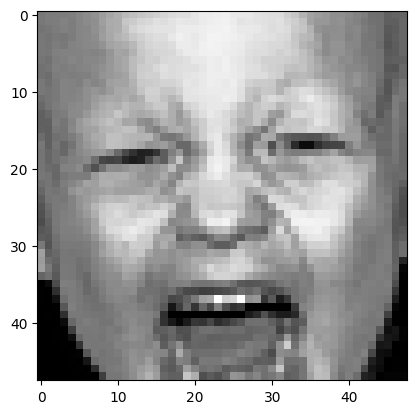

In [21]:
plt.imshow(balanced_df['image'][2343],cmap = 'gray')
